In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load Data and Visualise it

In [2]:
data = pd.read_csv("data/dataset_1.csv", sep=",")
data.head()

,ts,acc,pos
0,0.000000,-0.003530,0.000000
1,0.005001,-0.000897,0.000033
2,0.010002,-0.000376,0.000066
3,0.015003,-0.001351,0.000098
4,0.020004,-0.007139,0.000131


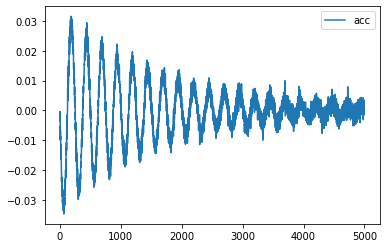

In [3]:
data.plot(y="acc")

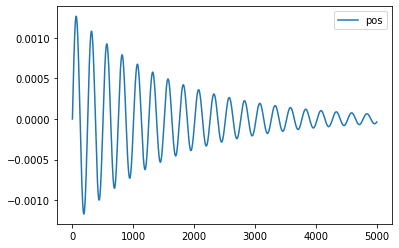

In [4]:
data.plot(y="pos")

In [5]:
data.shape

(4999, 3)

In [6]:
from sklearn.preprocessing import MinMaxScaler
# Normalising the Data
sc = MinMaxScaler()
data = sc.fit_transform(data)

In [7]:
train_len = int(0.8 * data.shape[0])
test_len = data.shape[0] - train_len
print(train_len)
print(test_len)

3999
1000


In [8]:
# Getting Input and Output Data
#data_x_ = data[["acc"]].values
#data_y_ = data[["pos"]].values

data_x_ = data[:, 1:2]
data_y_ = data[:, 2:3]

In [9]:
def sliding_windows(data_x, data_y, window_size):
    x = []
    y = []
    assert data_x.shape[0] == data_y.shape[0]
    for i in range(len(data_y)-window_size-1):
        _x = data_x[i:(i+window_size)]
        _y = data_y[i+window_size]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [10]:
window_size = 3

data_x, data_y = sliding_windows(data_x_, data_y_, window_size)
print(" Data X Shape:", data_x.shape)
print(" Data Y Shape:", data_y.shape)

 Data X Shape: (4995, 3, 1)
 Data Y Shape: (4995, 1)


In [11]:
# Changing this data into tensors
data_X = torch.Tensor(data_x)
data_Y = torch.Tensor(data_y)
print(" Data X Shape:", data_X.shape)
print(" Data Y Shape:", data_Y.shape)

 Data X Shape: torch.Size([4995, 3, 1])
 Data Y Shape: torch.Size([4995, 1])


##### Train - Test Split

In [12]:
data_x_train = Variable(torch.Tensor(data_x[:train_len]))
data_y_train = Variable(torch.Tensor(data_y[:train_len]))

data_x_test = Variable(torch.Tensor(data_x[train_len:]))
data_y_test = Variable(torch.Tensor(data_y[train_len:]))

print("Train tesnsor shape", data_x_train.shape)
print("Test tesnsor shape", data_x_test.shape)

Train tesnsor shape torch.Size([3999, 3, 1])
Test tesnsor shape torch.Size([996, 3, 1])


### Defining the LSTM Model

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [14]:
# Model Parameters
num_epochs = 5000
learning_rate = 0.0001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [15]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [16]:
data_x_train.shape

torch.Size([3999, 3, 1])

In [17]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(data_x_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, data_y_train)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.48784
Epoch: 100, loss: 1.43003
Epoch: 200, loss: 1.37112
Epoch: 300, loss: 1.31068
Epoch: 400, loss: 1.24863
Epoch: 500, loss: 1.18504
Epoch: 600, loss: 1.12009
Epoch: 700, loss: 1.05410
Epoch: 800, loss: 0.98749
Epoch: 900, loss: 0.92080
Epoch: 1000, loss: 0.85464
Epoch: 1100, loss: 0.78963
Epoch: 1200, loss: 0.72641
Epoch: 1300, loss: 0.66554
Epoch: 1400, loss: 0.60753
Epoch: 1500, loss: 0.55275
Epoch: 1600, loss: 0.50145
Epoch: 1700, loss: 0.45378
Epoch: 1800, loss: 0.40977
Epoch: 1900, loss: 0.36938
Epoch: 2000, loss: 0.33248
Epoch: 2100, loss: 0.29891
Epoch: 2200, loss: 0.26847
Epoch: 2300, loss: 0.24095
Epoch: 2400, loss: 0.21614
Epoch: 2500, loss: 0.19381
Epoch: 2600, loss: 0.17376
Epoch: 2700, loss: 0.15580
Epoch: 2800, loss: 0.13974
Epoch: 2900, loss: 0.12541
Epoch: 3000, loss: 0.11265
Epoch: 3100, loss: 0.10132
Epoch: 3200, loss: 0.09128
Epoch: 3300, loss: 0.08242
Epoch: 3400, loss: 0.07462
Epoch: 3500, loss: 0.06777
Epoch: 3600, loss: 0.06179
Epoch: 3700, 

In [18]:
print(" Data X Shape:", data_X.shape)
print(" Data Y Shape:", data_Y.shape)

 Data X Shape: torch.Size([4995, 3, 1])
 Data Y Shape: torch.Size([4995, 1])


In [19]:
lstm.eval()
train_predict = lstm(data_X)

data_predict = train_predict.data.numpy()
dataY_plot = data_Y.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_len, c='r', linestyle='--')

plt.plot(dataY_plot, label="GT")
plt.plot(data_predict, label="Predicted")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

ValueError: non-broadcastable output operand with shape (4995,1) doesn't match the broadcast shape (4995,3)